In [454]:
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

from currency_converter import CurrencyConverter
c = CurrencyConverter()
from pprint import pprint


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords       # List of common stopwords
stops  = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/awang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
API_KEY = ''
API_SECRET = ''

## findAllListingActive
https://www.etsy.com/developers/documentation/reference/listing#method_findalllistingactive

In [420]:
param = {
    'keywords': 'bohemian%20earring',
    'sort_on': 'score',
    'limit': 100
    
}
q = f'https://openapi.etsy.com/v2/listings/active?keywords={param["keywords"]}&sort_on={param["sort_on"]}&limit={param["limit"]}&api_key={API_KEY}'



In [421]:
response = json.loads(requests.get(q).text)

In [422]:
totalcount = response['count']
print(totalcount)

50100


In [423]:
# response['results'][0].keys()
# time.strftime('%Y-%m-%d', time.localtime(1624733267))

In [424]:
col = ['listing_id', 'user_id', 'title', 'description', 'creation_tsz', 
       'ending_tsz', 'price', 'currency_code', 'tags', 'materials', 'url', 'views', 
       'num_favorers', 'item_weight', 'item_weight_unit', 'item_length', 
       'item_width', 'item_height', 'item_dimensions_unit', 'style', 'taxonomy_id', 'taxonomy_path', ]

In [425]:
dictfilt = lambda x, y: dict([(i,x[i]) for i in x if i in set(y)])
item_list = []
for item in response['results']:
    item_list.append(dictfilt(item, col))
df = pd.DataFrame(item_list)  

In [426]:
print(len(df))

100


In [427]:
df.head(1)

,listing_id,user_id,title,description,creation_tsz,ending_tsz,price,currency_code,tags,materials,...,num_favorers,item_weight,item_weight_unit,item_length,item_width,item_height,item_dimensions_unit,style,taxonomy_id,taxonomy_path
0,955866842,121693236,"Small Macrame Earrings, Everyday Bohemian Earr...","Beautiful Small and cute Macrame Earrings, lig...",1615175304,1625712504,25.00,EUR,"[woven earrings, macrame earrings, small earri...",[Polyester],...,17,None,g,None,None,None,mm,None,1684,"[Weddings, Jewelry, Earrings]"


In [431]:
def df_formatter(df):
    # string to in
    df['price'] = df['price'].astype(float)
    # time convert
    time_col = ['creation_tsz', 'ending_tsz']
    for t in time_col:
        try:
            df[t] = pd.to_datetime(df[t], unit='s').dt.date
        except:
            df[t] = df[t]
    # price convert
    df['d_price'] = df.apply(lambda x: c.convert(x['price'], x['currency_code'], 'USD'), axis=1)
    return df   

In [432]:
df = df_formatter(df)

## Currency



In [433]:
data = []
for c in list(df['currency_code'].unique()):
    data.append(np.array(df[df['currency_code'] == c]['d_price']))

In [434]:
x = np.array(df['currency_code'].unique())

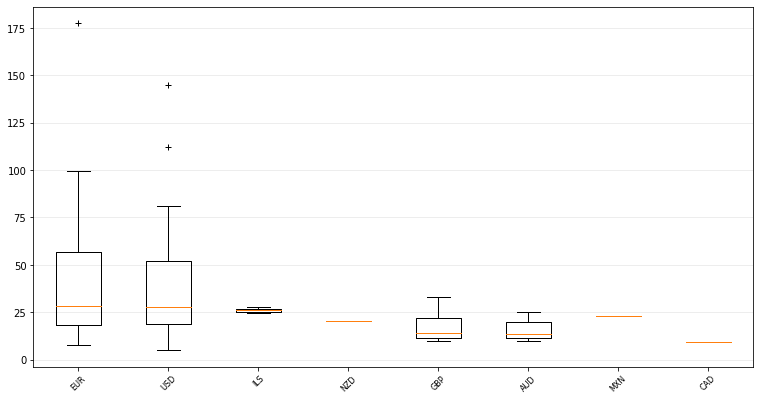

In [435]:
fig = plt.figure(figsize =(10, 5)) 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
bp = ax.boxplot(data, notch=0, sym='+', vert=1, whis=1.5) 
ax.set_xticklabels(df['currency_code'].unique(),
                   rotation=45, fontsize=8)
plt.show() 

In [436]:
df.groupby(['currency_code'])['d_price']\
    .describe()\
    .sort_values(by=['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
currency_code,,,,,,,,
USD,53.0,36.629434,26.680619,4.990000,19.000000,28.000000,52.000000,145.000000
EUR,25.0,41.925161,39.453436,7.870200,18.101460,28.090560,56.907600,177.624360
GBP,12.0,17.903820,8.278544,9.644675,11.552224,13.797819,21.900588,33.114765
AUD,5.0,16.066712,6.352216,10.008847,11.585530,13.525469,20.094983,25.118728
ILS,2.0,26.136577,2.174277,24.599131,25.367854,26.136577,26.905300,27.674023
CAD,1.0,9.423790,NaN,9.423790,9.423790,9.423790,9.423790,9.423790
MXN,1.0,22.966332,NaN,22.966332,22.966332,22.966332,22.966332,22.966332
NZD,1.0,20.132067,NaN,20.132067,20.132067,20.132067,20.132067,20.132067


#### Material & Pricing

In [ ]:
interested_cols = ['title', 'description','price','tags','materials',
                   'style', 'taxonomy_path', 'views','num_favorers', 'url']

In [464]:
materials_price_dicts = {}
for index, row in df[['materials', 'd_price', 'url']].iterrows():
    for s in row['materials']:
        i = [word for word in s.split( ) if word not in stops]
        for ii in i:
            k = ii.lower()
            if k in materials_price_dicts :
                materials_price_dicts[k].append(row['d_price'])
            else:
                materials_price_dicts[k]=[row['d_price']]
avgDict = {}
for k,v in materials_price_dicts.items():
    # v is the list of grades for student k
    avgDict[k] = sum(v)/ float(len(v))
sorted(avgDict.items(), key=lambda x:x[1], reverse=True)

[('onyx', 177.62436),
 ('crystal', 111.9),
 ('resin', 99.2856),
 ('synthetic', 99.2856),
 ('opal', 99.2856),
 ('métal', 82.3344),
 ('cuivre', 82.3344),
 ('nacre', 82.3344),
 ('aventurine', 82.3344),
 ('chalcedony', 82.3344),
 ('calcédoine', 82.3344),
 ('swarovski', 79.95),
 ('thread', 78.70200000000001),
 ('imitation', 78.70200000000001),
 ('pearls', 78.70200000000001),
 ('comb', 78.70200000000001),
 ('hooks', 65.82600000000001),
 ('rose', 60.0),
 ('white', 60.0),
 ('toho', 56.0),
 ('flowers', 56.0),
 ('dream', 56.0),
 ('catcher', 56.0),
 ('pearl', 55.6968),
 ('polyester', 54.65733333333335),
 ('see', 54.2),
 ('item', 54.2),
 ('details', 54.2),
 ('select', 54.2),
 ('description', 54.2),
 ('hand', 52.95000000000001),
 ('painted', 52.95000000000001),
 ('filigrees', 52.95000000000001),
 ('french', 52.95000000000001),
 ('picasso', 52.95000000000001),
 ('drops', 52.95000000000001),
 ('gold', 52.29),
 ('denim', 52.0),
 ('crochet', 52.0),
 ('fringe', 52.0),
 ('handmade', 52.0),
 ('clasp', 52.

In [396]:
# materials_dicts = {}
# for m in df['materials']:
#     for s in m:
#         i= s.split( )
#         for ii in i:
#             k = ii.lower()
#             if k in materials_dicts:
#                 materials_dicts[k]=materials_dicts[k]+1
#             else:
#                 materials_dicts[k]=1 
# sorted(materials_dicts.items(), key=lambda x:x[1], reverse=True)

In [384]:
df[df['currency_code']=='USD'][interested_cols].sort_values(by='price', ascending=False)

,title,description,price,tags,materials,style,taxonomy_path,views,num_favorers,url
90,"CASCADE | Floral bridal earrings, bohemian ear...",Inspired by our enduring love for Mother Natur...,145.00,"[wedding earrings, bridal earrings, drop earri...",[],None,"[Weddings, Jewelry, Earrings]",2025,166,https://www.etsy.com/listing/769207616/cascade...
95,"AQUAMARINE EARRINGS, Silver Blue Earrings, Swa...","AQUAMARINE EARRINGS, Silver Blue Earrings, Swa...",111.90,"[AQUAMARINE EARRINGS, Silver Blue Earrings, Sw...",[Swarovski Crystal],None,"[Weddings, Jewelry, Earrings]",108,15,https://www.etsy.com/listing/600236573/aquamar...
68,Leather Feather Multicolor Dream Catcher bohem...,"Green, black and yellow genuine leather Dream ...",81.00,"[green leather, Essence Cult, hypoallergenic s...","[Leather, Stainless steel]",None,"[Jewelry, Earrings, Dangle & Drop Earrings]",19,1,https://www.etsy.com/listing/740035402/leather...
41,"Genuine turquoise earrings, Bohemian Earrings,...",These small raw turquoise earrings are very st...,80.11,"[Genuine Turquoise, Turquoise Earrings, Births...","[Turquoise, Stone]","[Country Western, Boho]","[Weddings, Gifts & Mementos, Bridesmaids' Gift...",85,15,https://www.etsy.com/listing/633186392/genuine...
22,Extra big jewelry SET ring and earrings unusua...,Extra big jewelry SET ring and earrings unusua...,74.00,"[Extra big jewelry, jewelry SET, ring and earr...",[Silver],None,"[Jewelry, Jewelry Sets]",74,8,https://www.etsy.com/listing/702036863/extra-b...
26,"earrings, turquoise earrings, leverback earrin...",ON SALE\n\n ~such stunning new artisan inspire...,62.99,"[jewelry, earrings, bohemian earrings, boho ch...",[Turquoise],"[Boho, High Fashion]","[Jewelry, Earrings, Dangle & Drop Earrings]",13,3,https://www.etsy.com/listing/946238030/earring...
1,"Climber Earrings,Ear Climbers,Silver Earrings,...",A chic pair of silver stud earrings you can we...,60.00,"[ear crawler, ear climber, climber earrings, b...","[Brass, Silver, Gold, Rose gold, White gold]",None,"[Jewelry, Earrings, Ear Jackets & Climbers, Ea...",17,0,https://www.etsy.com/listing/886209052/climber...
38,White gem earrings long earrings Armenian jewe...,White gem earrings long earrings Armenian jewe...,59.90,"[earrings white, white gem, white agate jewelr...",[Silver],None,"[Jewelry, Jewelry Sets]",22,3,https://www.etsy.com/listing/907629845/white-g...
42,"Dream Catcher Earrings, White Boho Earrings, H...","Dream Catcher Earrings, White Boho Earrings, H...",56.00,"[crystal earrings, handmade earrings, statemen...","[Toho Beads, Glass Beads, Glass Crystals, Silk...","[Modern, Abstract]","[Weddings, Gifts & Mementos, Bridesmaids' Gift...",12,1,https://www.etsy.com/listing/929837858/dream-c...
8,"Leaf hoops, bohemian earrings, green earrings,...",These lovely earrings are handcraftet by me wi...,55.00,"[Leaf hoops, bohemian earrings, green earrings...","[Polyester, Brass]",None,"[Jewelry, Earrings, Hoop Earrings]",33,7,https://www.etsy.com/listing/899883793/leaf-ho...


## Auto generate description